In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**IMPORT REQUIRED PACKAGES**









In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

#**DEEP NEURAL NETWORK CLASS**

In [2]:
class Deep_Neural_Network :

  def create(self,input_size,output_size,hidden_dims,output_type,initializer='random',
             seed=None,activation='relu',leaky_relu_slope=0.1):
    """
    The method to define the architecture of Deep Neural Network and initialize weights.

    Parameters:

    input_size(int)       :   No. of neurons in input layer.
    
    output_size(int)      :   No. of classes in classification task (2 in case of binary classification,
                              modify the dataset accordingly !)
                              (or) No. of Target variables in case of regression task.

    hidden_dims(int list) :   No. of neurons in hidden layers.

    output_type(string)   :   Type of task :
                              'classification'  :  Classification (discrete target).
                              'regression'      :  Regression (continuous target).

    initializer(string)   :   Weight initializer :
                              'random'  : Random initialization.
                              'xavier'  : Xavier initialization (preferred for tanh activation).
                              'he'      : He initialization (preferred for ReLU activation).

    seed(int)             :   NumPy seed for random initialization.

    activation(string)    :   Activation function for hidden layers. One of the following :
                              'linear'  : Linear activation.
                              'sigmoid' : Sigmoid activation.
                              'tanh'    : Hyberbolic tangent activation.
                              'relu'    : Rectified Linear Unit activation.
                              'lrelu'   : Leaky Rectified Linear Unit activation.

                              Activation function at output layer would be SoftMax for classification
                              and Linear for regression.

    leaky_relu_slope(int) :   Slope for Leaky ReLU activation.   

    """
    self.layer_dims=[input_size]+hidden_dims+[output_size]
    self.W = {}
    self.b = {}
    self.activation = activation
    self.leaky_relu_slope = leaky_relu_slope
    self.initializer = initializer
    self.output_type = output_type

    self.L = len(self.layer_dims)-1

    if seed != None:
      np.random.seed(seed)

    for i in range(self.L):
      self.W[i+1] = np.random.randn(self.layer_dims[i+1],self.layer_dims[i])
      self.b[i+1] = np.zeros((self.layer_dims[i+1],1))

    if self.initializer == 'xavier':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(1/(self.layer_dims[i]))

    elif self.initializer == 'he':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(2/(self.layer_dims[i]))



  def save_weights(self):
    """
    The method to save model weights.

    Returns :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    return (self.W,self.b)

  

  def load_weights(self,params):
    """
    The method to load model weights.

    Parameters :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    self.W = params[0]
    self.b = params[1]



  ### ACTIVATION FUNCTIONS AND THEIR GRADIENTS ###

  def linear(self,X):
    return X

  def linear_grad(self,X):
    return np.ones(shape=X.shape) 

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def sigmoid_grad(self,X):
    return self.sigmoid(X)*(1-self.sigmoid(X))

  def tanh(self,X):
    return np.tanh(X)

  def tanh_grad(self,X):
    return 1-((self.tanh(X))**2)

  def relu(self,X):
    return np.maximum(0,X)

  def relu_grad(self,X):
    return 1.0*(X>0)

  def lrelu(self,X):
    return np.where(X > 0, X, X * self.leaky_relu_slope)

  def lrelu_grad(self,X):
    return np.where(X > 0, 1, self.leaky_relu_slope)   

  def softmax(self,X):
    exps = np.exp(X-np.max(X))
    return exps/np.sum(exps,axis=0)



  def to_one_hot(self,X):
    """
    The method to convert SoftMax probabilities to label in one hot form.

    Parameters :

    X(NumPy 2D array of shape (output_size,m))  : Predicted SoftMax probabilities for batch of size m.

    Returns :

    X_one_hot(NumPy 2D array of shape (output_size,m)) : Predicted labels in one hot form for batch of 
                                                         size m.

    """
    a = np.argmax(X,axis=0)
    b = np.zeros((X.shape[0],a.size))
    b[a,np.arange(a.size)] = 1
    return b



  def accuracy(self,Y_pred,Y_true):
    """
    The method to calculate classification accuracy.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted labels for batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Actual labels for batch of size m.

    Returns :

    accuracy(float)   : Accuracy in range [0,1].

    """
    a = np.argmax(Y_pred,axis=0)
    b = np.argmax(Y_true,axis=0)

    correct = np.sum((a==b)*1)
    total = a.size

    return correct/total



  def forward_propagation(self,X,dropout=False):
    """
    The method to forward propagate input data through the network, and calculate activations of 
    each layer.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    dropout(boolean)                           : Perform dropout or not.

    Returns :

    activations(dictionary)   : Activations of all layers.

    """
    self.Z = {}
    self.A = {}

    self.A[0] = X

    for i in range (len(self.layer_dims)-2):
      self.Z[i+1] = np.matmul(self.W[i+1],self.A[i])+self.b[i+1]
      _ = "self.A[i+1] = self."+self.activation+"(self.Z[i+1])"
      exec(_)

      if dropout == True:
        self.A[i+1] *= ((np.random.rand(self.A[i+1].shape[0],self.A[i+1].shape[1])<self.keep_probs[i])*1)
        self.A[i+1].reshape(1,-1)
        self.A[i+1] /= self.keep_probs[i]

    self.Z[self.L] = np.matmul(self.W[self.L],self.A[len(self.layer_dims)-2])+self.b[self.L]

    if self.output_type == 'classification':
      self.A[self.L] = self.softmax(self.Z[self.L])

    elif self.output_type == 'regression':
      self.A[self.L] = self.Z[self.L] 

    return self.A



  def compute_cost(self,Y_pred,Y_true):
    """
    The method to compute cost for the current forward propagated batch.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted outputs for current forward propagated 
                                                       batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch
                                                       of size m.

    Returns :

    cost(float)   : Cost for current forward propagated batch.

    """
    if self.output_type=='classification':
      cost = (1/Y_true.shape[1])*np.sum(-1*Y_true*np.log(Y_pred))

    else:
      cost = (1/(2*Y_true.shape[1]))*np.sum((Y_pred-Y_true)**2)

    sum=0

    if self.regularizer == 'l2':
      for i in range(self.L):
        sum += np.sum(self.W[i+1]**2)
      cost += ((1/(2*Y_true.shape[1]))*sum)      

    elif self.regularizer == 'l1':
      for i in range(self.L):
        sum += np.sum(np.abs(self.W[i+1]))
      cost += ((1/Y_true.shape[1])*sum)   
    
    return cost



  def backward_propagation(self,Y):
    """
    The method to compute gradient of cost with respect to weights and biases of each layer.

    Parameters :

    Y(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch 
                                                  of size m.

    Returns :

    gradients(tuple)   : Tuple containing gradients of cost with respect to weights and biases of each 
                         layer in form of dictionaries.

    """
    self.dZ = {}
    self.dA = {}
    self.dW = {}
    self.db = {}

    self.dZ[self.L] = self.A[self.L]-Y

    for i in range(self.L,0,-1):

      self.dW[i] = (1/self.dZ[i].shape[1])*np.matmul(self.dZ[i],self.A[i-1].T)

      if self.regularizer == 'l2':
        self.dW[i] += self.regularizer_lambda*self.W[i]
      elif self.regularizer == 'l1':
        self.dW[i] += self.regularizer_lambda*np.where(self.W[i]>0,1,-1) 
        
      self.db[i] = (1/self.dZ[i].shape[1])*np.sum(self.dZ[i],axis=1,keepdims=True)
      _ = "self.dZ[i-1] = np.matmul(self.W[i].T,self.dZ[i])*self."+self.activation+"_grad(self.A[i-1])"
      exec(_) 
      
    return (self.dW,self.db)
  


  def train(self,X_train,Y_train,X_val,Y_val,optimizer='vanilla',regularizer=None,regularizer_lambda=0.02,
            keep_probs=[],mini_batch_size=32,epochs=100,learning_rate=0.01,beta=0.9,beta1=0.9,beta2=0.99,
            print_loss_freq=100,plot_loss=True):
    """
    The method to train the weights and biases of each layer for the provided training data with 
    ground truths.

    Parameters :

    X_train(NumPy 2D array of shape(input_size,m))   :  Input data(for batch of size m) for training.

    Y_train(NumPy 2D array of shape(output_size,m))  :  Ground truths(for batch of size m) for training.

    X_val(NumPy 2D array of shape(input_size,m))     :  Input data(for batch of size m) for validation.

    Y_val(NumPy 2D array of shape(output_size,m))    :  Ground truths(for batch of size m) for validation.

    optimizer(string)             :   Optimizer for training process, one of the following :
                                      'vanilla'     : Original gradient decsent.
                                      'momentum'    : Gradient descent with momentum.
                                      'rmsprop'     : Root mean square propagation.
                                      'adam'        : Adaptive moments estimation.
    
    regularizer(string)           :   Regularizer for weights of network, one of the following :
                                      'l1'      : L1 regularization.
                                      'l2'      : L2 regularization.
                                      'dropout' : Dropout regularization.
                                      None      : No regularizer.

    regularizer_lambda(float)     :   Regularization parameter lambda for L1 or L2 regularization.

    keep_probs(float[0,1] list)   :   Keeping probabilities for hidden layers in Dropout regularization.

    mini_batch_size(int)          :   Mini Batch size (1 for Stochastic gradient descent).

    epochs(int)                   :   No. of iterations over training set.

    learning_rate(float)          :   Learning rate aplha.

    beta(float)                   :   Optimizer parameter beta for 'momentum' and 'rmsprop' optimizers.

    beta1(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    beta2(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    print_loss_freq(int)          :   Frequency of printing metrics.

    plot_loss(boolean)            :   Plot learning curves or not.

    Returns :

    Metrics_history(tuple)        :   History of metrics in form of lists

    """
    self.regularizer_lambda = regularizer_lambda
    self.regularizer = regularizer

    if keep_probs != []:
      self.keep_probs = keep_probs
    else:
      self.keep_probs = [1]*(len(self.layer_dims)-2)

    self.print_loss_freq = print_loss_freq  

    self.Mw = {}
    self.Mb = {}
    self.Vw = {}
    self.Vb = {}

    for i in range(self.L):
      self.Mw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Mb[i+1] = np.zeros(shape=self.b[i+1].shape)
      self.Vw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Vb[i+1] = np.zeros(shape=self.b[i+1].shape)

    train_cost = []
    val_cost = []
    train_acc = []
    val_acc = []
    m = X_train.shape[1]

    drop = False
    if(self.regularizer == 'dropout'):
      drop = True

    t = 1
    
    for e in range(epochs):

      mask = np.random.permutation(m)

      X_train = X_train[:,mask]
      Y_train = Y_train[:,mask]

      if optimizer == 'vanilla':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.dW[i+1]
            self.b[i+1] -= learning_rate*self.db[i+1]

      elif optimizer == 'momentum':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Mw[i+1] = (beta*self.Mw[i+1])+(1-beta)*self.dW[i+1]
            self.Mb[i+1] = (beta*self.Mb[i+1])+(1-beta)*self.db[i+1]
          
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.Mw[i+1]
            self.b[i+1] -= learning_rate*self.Mb[i+1]

      elif optimizer == 'rmsprop':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Vw[i+1] = (beta*self.Vw[i+1])+(1-beta)*(self.dW[i+1]**2)
            self.Vb[i+1] = (beta*self.Vb[i+1])+(1-beta)*(self.db[i+1]**2)
          
          for i in range(self.L):
            
            self.W[i+1] -= learning_rate*(self.dW[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.db[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      elif optimizer == 'adam':
        
        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):

            self.Mw[i+1] = (beta1*self.Mw[i+1])+(1-beta1)*self.dW[i+1]
            #self.Mw[i+1] /= (1-np.power(beta1,t))
            self.Mb[i+1] = (beta1*self.Mb[i+1])+(1-beta1)*self.db[i+1]
            #self.Mb[i+1] /= (1-np.power(beta1,t))

          for i in range(self.L):
            self.Vw[i+1] = (beta2*self.Vw[i+1])+(1-beta2)*(self.dW[i+1]**2)
            #self.Vw[i+1] /= (1-np.power(beta2,t))
            self.Vb[i+1] = (beta2*self.Vb[i+1])+(1-beta2)*(self.db[i+1]**2)
            #self.Vb[i+1] /= (1-np.power(beta2,t))

          t += 1  

          for i in range(self.L):
            self.W[i+1] -= learning_rate*(self.Mw[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.Mb[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      Y_pred_train = self.forward_propagation(X_train)[self.L]
      Y_pred_val = self.forward_propagation(X_val)[self.L]
                                   
      train_cost.append(self.compute_cost(Y_pred_train,Y_train))
      val_cost.append(self.compute_cost(Y_pred_val,Y_val))

      train_acc.append(self.accuracy(self.to_one_hot(Y_pred_train),Y_train))
      val_acc.append(self.accuracy(self.to_one_hot(Y_pred_val),Y_val))

      if (e+1)%self.print_loss_freq==0:
        if self.output_type == 'classification':
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) +
                "    Validation Loss = "+str(val_cost[e]) + "\n\n\t\t " +
                "    Training Accuracy = "+str(train_acc[e]) +
                "    Validation Accuracy = "+str(val_acc[e])+'\n')
        else:
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) + 
                "    Validation Loss = "+str(val_cost[e])+'\n')  

    if plot_loss == True:

      r = list(range(1,epochs+1))
      plt.plot(r,train_cost,'r',label="Training Loss")
      plt.plot(r,val_cost,'b',label="Validation Loss")
      plt.xlabel('Epochs')
      if self.output_type == 'regression':
        plt.ylabel('L2 Loss')
      else:
        plt.ylabel('Categorical Cross Entropy Loss') 
      plt.legend()
      plt.show()

      print("\nTraining Loss : ",train_cost[-1])
      print("\nValidation Loss : ",val_cost[-1]) 

      if self.output_type == 'classification':
        print("\nTraining Accuracy : ",train_acc[-1])
        print("\nValidation Accuracy : ",val_acc[-1]) 

    return (train_cost,val_cost,train_acc,val_acc)       



  def predict(self,X):
    """
    The method to predict outputs for given unknown input data.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    Returns :

    Y_pred(NumPy 2D array of shape (output_size_size,m))  : Predicted output for batch of size m.

    """

    A = self.forward_propagation(X)

    if self.output_type == 'regression':
      return A[self.L]
    else:
      return self.to_one_hot(A[self.L])


#**REGRESSION on Human Perception dataset**

In [26]:
X=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Train_data_x1.csv', encoding = 'ISO-8859-1')
selectF=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'user_debora',
       'user_katia', 'user_wallace', 'user_jose_carlos', 'gender_Woman',
       'gender_Man', 'class_sitting', 'class_sittingdown', 'class_standing',
       'class_standingup', 'class_walking']
Xtrain = X[selectF]
ytrain = X['x1']
ytrain = ytrain.values.reshape(-1,1)
Xtrain.shape,ytrain.shape

((132506, 26), (132506, 1))

In [27]:
X=Xtrain
Y=ytrain

In [28]:
X=X.to_numpy()
type(Y)

numpy.ndarray

In [29]:
X=X[:10000,:]
Y=Y[:10000,:]

In [30]:
X.shape, Y.shape

((10000, 26), (10000, 1))

In [31]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(X, Y, test_size = 0.25)

In [32]:
X.shape

(7500, 26)

In [33]:
# Normalize, reshape and split into train, test and validation datasets.

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1)

Y_train = Y_train.reshape(1,Y_train.shape[0])
Y_val = Y_val.reshape(1,Y_val.shape[0])

X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val = (X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

In [36]:
print(X_train.shape, "\n",X_val.shape, "\n", Y_train.shape,"\n",Y_val.shape,"\n")
print(type(X_train), "\n",type(X_val), "\n", type(Y_train),"\n",type(Y_val),"\n")

(6750, 26) 
 (750, 26) 
 (1, 6750) 
 (1, 750) 

<class 'numpy.ndarray'> 
 <class 'numpy.ndarray'> 
 <class 'numpy.ndarray'> 
 <class 'numpy.ndarray'> 



## Train Data for the new method

In [85]:
X=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Train_data.csv', encoding = 'ISO-8859-1')
selFeat=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
X=X[selFeat]
Xarr=X.to_numpy()
arr = np.random.binomial(1, 0.5, X.shape)
indices=np.where(arr==0)
Xtransformed=Xarr.astype('float')
Xtransformed[indices]=np.nan
XtransDataframe=pd.DataFrame(Xtransformed,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
Xtrain = XtransDataframe
ytrain=pd.DataFrame(Xarr,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])

In [86]:
Xtrain=Xtrain.to_numpy()
ytrain=ytrain.to_numpy()

In [87]:
Xtrain[0]

array([ 7., 91., nan, 26., 39., nan, 15., nan, nan, nan, nan, nan])

In [88]:
ytrain[0]

array([   7,   91,  -87,   26,   39, -124,   15,  108,  -88, -179, -106,
       -173])

In [89]:
Xtrain_orig_nan=Xtrain.copy()
ytrain_orig_nan=ytrain.copy()

In [59]:
X_train_nan=Xtrain_orig_nan[:99379,:].copy()
X_test_nan=Xtrain_orig_nan[99380:132000,:].copy()
X_val_nan=Xtrain_orig_nan[132001:132507,:].copy()

In [90]:
Y_train_nan=ytrain_orig_nan[:99379,:].copy()
Y_test_nan=ytrain_orig_nan[99380:132000,:].copy()
Y_val_nan=ytrain_orig_nan[132001:132507,:].copy()

In [91]:
X_train=X_train_nan.copy()
X_test=X_test_nan.copy()
X_val=X_val_nan.copy()

In [92]:
Y_train=Y_train_nan.copy()
Y_test=Y_test_nan.copy()
Y_val=Y_val_nan.copy()

In [93]:
X_train[0]

array([   7.,   nan,   nan,   nan,   39., -124.,   15.,  108.,  -88.,
         nan, -106., -173.])

In [94]:
Y_train[0]

array([   7,   91,  -87,   26,   39, -124,   15,  108,  -88, -179, -106,
       -173])

In [95]:
X_test[0]

array([  -7.,   nan,  -90.,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,  -99., -156.])

In [96]:
Y_test[0]

array([  -7,   95,  -90,    3,   71, -118,   22,  104,  -84, -160,  -99,
       -156])

In [97]:
X_val[0]

array([   7.,   68.,  -65.,  -20.,   nan,  -25.,   84.,   76.,  -98.,
        -89., -126., -169.])

In [98]:
Y_val[0]

array([   7,   68,  -65,  -20,  -34,  -25,   84,   76,  -98,  -89, -126,
       -169])

In [99]:
col_mean = np.nanmean(X_train, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_train))
#Place column means in the indices. Align the arrays using take
X_train[inds] = np.take(col_mean, inds[1])
X_train[0]

array([   7.        ,   88.38737993,  -93.07633955,  -87.05963201,
         39.        , -124.        ,   15.        ,  108.        ,
        -88.        , -167.76386487, -106.        , -173.        ])

In [100]:
col_mean = np.nanmean(X_test, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_test))
#Place column means in the indices. Align the arrays using take
X_test[inds] = np.take(col_mean, inds[1])
# print(X_train)
X_test[0]

array([  -7.        ,   88.33870771,  -90.        ,  -88.36235453,
        -54.8398524 , -175.34202313,   17.70285257,  104.34612537,
        -93.72059649, -168.02803911,  -99.        , -156.        ])

In [101]:
col_mean = np.nanmean(X_val, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(X_val))
#Place column means in the indices. Align the arrays using take
X_val[inds] = np.take(col_mean, inds[1])
# print(X_train)
X_val[0]

array([   7.       ,   68.       ,  -65.       ,  -20.       ,
        -65.9626556,  -25.       ,   84.       ,   76.       ,
        -98.       ,  -89.       , -126.       , -169.       ])

In [102]:
print(X_train.shape, "\n",Y_train.shape,"\n",\
      X_test.shape,"\n",Y_test.shape, "\n",\
      X_val.shape,"\n",Y_val.shape)

(99379, 12) 
 (99379, 12) 
 (32620, 12) 
 (32620, 12) 
 (505, 12) 
 (505, 12)


In [103]:
# Normalize, reshape and split into train, test and validation datasets.
Y_train = Y_train.T.copy()
Y_val = Y_val.T.copy()
Y_test = Y_test.T.copy()

# X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0).copy()
# X_val = (X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0).copy()
# X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0).copy()

In [104]:
print(X_train.shape, "\n",Y_train.shape,"\n",\
      X_test.shape,"\n",Y_test.shape, "\n",\
      X_val.shape,"\n",Y_val.shape)

(99379, 12) 
 (12, 99379) 
 (32620, 12) 
 (12, 32620) 
 (505, 12) 
 (12, 505)


In [105]:
X_train_nan[0]

array([   7.,   nan,   nan,   nan,   39., -124.,   15.,  108.,  -88.,
         nan, -106., -173.])

In [178]:
X_train[0]

array([   7.        ,   88.38737993,  -93.07633955,  -87.05963201,
         39.        , -124.        ,   15.        ,  108.        ,
        -88.        , -167.76386487, -106.        , -173.        ])

In [107]:
Y_train[:,0]

array([   7,   91,  -87,   26,   39, -124,   15,  108,  -88, -179, -106,
       -173])

After 10 epochs :    Training Loss = 10062.541834183685    Validation Loss = 10140.378316487862

After 20 epochs :    Training Loss = 9645.449216278861    Validation Loss = 10530.420689955046

After 30 epochs :    Training Loss = 9611.03438415265    Validation Loss = 10246.464872801205

After 40 epochs :    Training Loss = 9702.35519766487    Validation Loss = 12463.866486098268

After 50 epochs :    Training Loss = 9467.799785506319    Validation Loss = 10360.413948420764

After 60 epochs :    Training Loss = 9066.912677814493    Validation Loss = 10347.886626599138

After 70 epochs :    Training Loss = 9303.35709643927    Validation Loss = 10486.942283821547

After 80 epochs :    Training Loss = 9437.548239643262    Validation Loss = 11942.74651044944

After 90 epochs :    Training Loss = 9233.35996940946    Validation Loss = 11251.94265598156

After 100 epochs :    Training Loss = 9042.57775964132    Validation Loss = 10369.515390118047



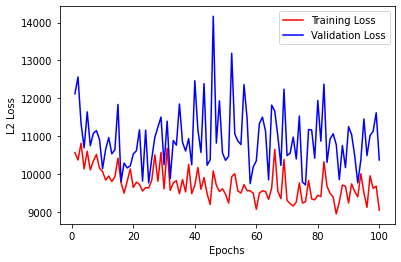


Training Loss :  9042.57775964132

Validation Loss :  10369.515390118047


In [199]:
# Define and train the Deep Neural Network.
model = Deep_Neural_Network()

model.create(12,12,[120,120,120],output_type='regression',activation='relu',initializer='he')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='adam',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=50,epochs=100,print_loss_freq=10,
                    learning_rate=0.02)

In [200]:
# Predict output for test dataset.

Y_p = model.predict(X_test.T)

In [201]:
Y_test.shape

(12, 32620)

In [130]:
# Calculate Loss for test dataset

print(model.compute_cost(Y_p,Y_test.reshape(1,33127)))

In [202]:
Y_p=Y_p.T

In [203]:
Y_test

array([[  -7,   -4,  -40, ...,    3,    4,  -15],
       [  95,   75,   60, ...,   69,   71,   95],
       [ -90,  -34, -143, ...,  -62,  -63, -147],
       ...,
       [-160, -153, -224, ...,  -96,  -94, -176],
       [ -99, -109,  -61, ..., -127, -127,  -74],
       [-156, -166, -177, ..., -166, -147, -158]])

In [204]:
Y_p.shape

(32620, 12)

In [205]:
Y_tes=Y_test.T

In [206]:
Y_tes.shape

(32620, 12)

In [207]:
df = pd.DataFrame(data=Y_p[0], columns=["predicted"])
df["fullFilledValues"]=Y_tes[0]
df["MisingValueInput"]=X_test[0]
df["withNan"]=X_test_nan[0]
df.head(20)

,predicted,fullFilledValues,MisingValueInput,withNan
0,-7.743809,-7,-7.000000,-7.0
1,73.988565,95,88.338708,NaN
2,-63.720395,-90,-90.000000,-90.0
3,-54.625107,3,-88.362355,NaN
4,-26.140254,71,-54.839852,NaN
5,-121.001316,-118,-175.342023,NaN
6,19.684914,22,17.702853,NaN
7,100.521785,104,104.346125,NaN
8,-89.990656,-84,-93.720596,NaN
9,-157.554841,-160,-168.028039,NaN


In [208]:
df = pd.DataFrame(data=Y_p[1], columns=["predicted"])
df["fullFilledValues"]=Y_tes[1]
df["MisingValueInput"]=X_test[1]
df["withNan"]=X_test_nan[1]
df.head(20)

,predicted,fullFilledValues,MisingValueInput,withNan
0,-0.997182,-4,-6.472209,NaN
1,82.776237,75,88.338708,NaN
2,-50.439289,-34,-34.000000,-34.0
3,-15.706669,-2,-88.362355,NaN
4,10.241936,22,22.000000,22.0
5,-25.477554,-32,-175.342023,NaN
6,14.799395,2,2.000000,2.0
7,94.289443,94,104.346125,NaN
8,-82.993945,-72,-72.000000,-72.0
9,-147.188130,-153,-153.000000,-153.0


## Validations

In [224]:
X_Val=pd.read_csv('/Users/harsha/Desktop/myProjects/Fall2020-Local/ML/CS536FinalProject/ML-FinalProject/Datasets/Test_data.csv', encoding = 'ISO-8859-1')

In [225]:
selFeat=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']

In [226]:
X_Val=X_Val[selFeat]

In [227]:
Xarr_val=X_Val.to_numpy()

In [228]:
arr = np.random.binomial(1, 0.5, Xarr_val.shape)

In [229]:
indices=np.where(arr==0)

In [230]:
trueVals=Xarr_val[indices]

In [231]:
Xtransformed=Xarr_val.astype('float')
Xtransformed[indices]=np.nan

In [232]:
Xtest=Xtransformed.copy()

In [258]:
Xtransformed

array([[  -4.,   80.,  -82., ..., -179.,  -91., -178.],
       [ -14.,   nan,   nan, ...,   nan,  -81., -173.],
       [  -1.,   69.,  -66., ..., -102.,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ..., -161., -109.,   nan],
       [   0.,   nan, -149., ...,   nan,  -94.,   nan],
       [  nan,  105.,   nan, ...,   nan,  -89.,   nan]])

In [259]:
XtestMode=Xtransformed.copy()

## Mode as BaseCompletion Agent

In [270]:
col_mode = stats.mode(Xarr_val)

# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(XtestMode))
#Place column means in the indices. Align the arrays using take
XtestMode[inds] = np.take(col_mode[0], inds[1])
# print(X_train)
XtestMode

array([[  -4.,   80.,  -82., ..., -179.,  -91., -178.],
       [ -14.,   95.,  -98., ..., -164.,  -81., -173.],
       [  -1.,   69.,  -66., ..., -102.,  -94., -163.],
       ...,
       [  -1.,   95.,  -98., ..., -161., -109., -163.],
       [   0.,   95., -149., ..., -164.,  -94., -163.],
       [  -1.,  105.,  -98., ..., -164.,  -89., -163.]])

## Mean as BaseCompletion Agent

array([  -6.78296355,   88.14229225,  -93.03267855,  -88.87716737,
        -53.10002412, -175.43574273,   17.54884729,  105.42623547,
        -94.12995996, -167.4319605 ,  -92.64127482, -159.61786361])

In [234]:
col_mean = np.nanmean(Xtest, axis=0)
# print(col_mean)
#Find indices that you need to replace
inds = np.where(np.isnan(Xtest))
#Place column means in the indices. Align the arrays using take
Xtest[inds] = np.take(col_mean, inds[1])
# print(X_train)
Xtest

array([[  -4.        ,   80.        ,  -82.        , ..., -179.        ,
         -91.        , -178.        ],
       [ -14.        ,   88.14229225,  -93.03267855, ..., -167.4319605 ,
         -81.        , -173.        ],
       [  -1.        ,   69.        ,  -66.        , ..., -102.        ,
         -92.64127482, -159.61786361],
       ...,
       [  -6.78296355,   88.14229225,  -93.03267855, ..., -161.        ,
        -109.        , -159.61786361],
       [   0.        ,   88.14229225, -149.        , ..., -167.4319605 ,
         -94.        , -159.61786361],
       [  -6.78296355,  105.        ,  -93.03267855, ..., -167.4319605 ,
         -89.        , -159.61786361]])

In [235]:
Xtest.shape

(33127, 12)

In [222]:
Xtest=pd.DataFrame(Xtransformed,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
ytest=pd.DataFrame(Xarr_val,columns=['x1', 'y1', 'z1',
       'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])

In [236]:
yPredict = model.predict(Xtest.T)

In [237]:
yPredict.shape

(12, 33127)

In [238]:
yPredict=yPredict.T

In [239]:
predict=yPredict[indices]

In [256]:
means=Xtest[indices]

In [ ]:
df = pd.DataFrame(data=predict, columns=["predicted"])
df["trueVals"]=trueVals
df["means"]=Xtest[indices]
df.head(20)

## True Vals vs Predicted Score

In [245]:
score = (((trueVals - predict) ** 2).sum() / ((trueVals - trueVals.mean()) ** 2).sum())
score

0.1490350456311631

## True Vals vs Mean Score

In [257]:
score = (((trueVals - means) ** 2).sum() / ((trueVals - trueVals.mean()) ** 2).sum())
score

0.5531200837473889

In [247]:
df['predicted'].iloc[:1000]

0       81.145737
1      -88.156935
2       92.393259
3     -124.098511
4     -121.162296
          ...    
995    -85.630863
996     -1.534365
997    -56.128092
998    -13.779224
999    -34.518084
Name: predicted, Length: 1000, dtype: float64

In [255]:
df.to_csv('results_NN_regression.csv',index=False)

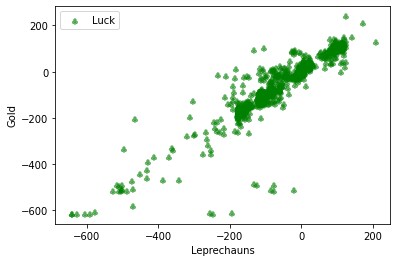

In [254]:
import matplotlib.pyplot as plt


x = df['predicted'].iloc[:1000].to_numpy()
y = df['trueVals'].iloc[:1000].to_numpy()
# s = np.random.rand(*x.shape) * 800 + 500

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.xlabel("Leprechauns")
plt.ylabel("Gold")
plt.legend(loc='upper left')
plt.show()

## Saving the model

In [272]:
import pickle

In [274]:
pickle.dump(model, open('NN_MultiImpute.pkl','wb'))

## open Pkl

In [277]:
modelNews=pickle.load(open('NN_MultiImpute.pkl','rb'))

In [278]:
modelNews

In [279]:
yPredictNew = modelNews.predict(Xtest.T)

In [280]:
yPredictNew

array([[  -6.41487588,   -5.14255314,    0.28788274, ...,   -1.06358375,
          -6.61952374,   -6.41487588],
       [  97.41935123,   92.39325915,   62.83298498, ...,   82.9557099 ,
          96.83167333,   97.41935123],
       [-107.81302742, -124.09851144,  -54.67609033, ...,  -51.142489  ,
        -114.64658481, -107.81302742],
       ...,
       [-179.01187994, -179.43280522,  -87.83410631, ..., -147.57817678,
        -184.64288236, -179.01187994],
       [ -85.54267913,  -61.05057724, -127.05328072, ..., -104.04451061,
         -86.00587761,  -85.54267913],
       [-158.23510144, -165.94879193, -168.20409301, ..., -158.81652235,
        -156.42596096, -158.23510144]])